<center>
    <p style="text-align:center">
        <img alt="phoenix logo" src="https://storage.googleapis.com/arize-assets/phoenix/assets/phoenix-logo-light.svg" width="200"/>
        <br>
        <a href="https://docs.arize.com/phoenix/">Docs</a>
        |
        <a href="https://github.com/Arize-ai/phoenix">GitHub</a>
        |
        <a href="https://join.slack.com/t/arize-ai/shared_invite/zt-1px8dcmlf-fmThhDFD_V_48oU7ALan4Q">Community</a>
    </p>
</center>

# Auto Generated Agent Chat: Task Solving with Code Generation, Execution & Debugging

AutoGen offers conversable LLM agents, which can be used to solve various tasks with human or automatic feedback, including tasks that require using tools via code.
Please find documentation about this feature [here](https://microsoft.github.io/autogen/docs/Use-Cases/agent_chat).

In this notebook, we demonstrate how to use `AssistantAgent` and `UserProxyAgent` to write code and execute the code. Here `AssistantAgent` is an LLM-based agent that can write Python code (in a Python coding block) for a user to execute for a given task. `UserProxyAgent` is an agent which serves as a proxy for the human user to execute the code written by `AssistantAgent`, or automatically execute the code. Depending on the setting of `human_input_mode` and `max_consecutive_auto_reply`, the `UserProxyAgent` either solicits feedback from the human user or returns auto-feedback based on the result of code execution (success or failure and corresponding outputs) to `AssistantAgent`. `AssistantAgent` will debug the code and suggest new code if the result contains error. The two agents keep communicating to each other until the task is done.

## Requirements

AutoGen requires `Python>=3.8`. To run this notebook example, please install:
```bash
pip install pyautogen
```

In [ ]:
pip install pyautogen~=0.2.2 openai==1.3

## Set your API Endpoint

The [`config_list_from_json`](https://microsoft.github.io/autogen/docs/reference/oai/openai_utils#config_list_from_json) function loads a list of configurations from an environment variable or a json file.


In [ ]:
import autogen

# ARIZE
config_list = [
    {
        "model": "gpt-4",
        "api_key": "<your-api-keys>",
    }
]

It first looks for environment variable "OAI_CONFIG_LIST" which needs to be a valid json string. If that variable is not found, it then looks for a json file named "OAI_CONFIG_LIST". It filters the configs by models (you can filter by other keys as well). Only the gpt-4 models are kept in the list based on the filter condition.

The config list looks like the following:
```python
config_list = [
    {
        'model': 'gpt-4',
        'api_key': '<your OpenAI API key here>',
    },
    {
        'model': 'gpt-4',
        'api_key': '<your Azure OpenAI API key here>',
        'api_base': '<your Azure OpenAI API base here>',
        'api_type': 'azure',
        'api_version': '2023-06-01-preview',
    },
    {
        'model': 'gpt-4-32k',
        'api_key': '<your Azure OpenAI API key here>',
        'api_base': '<your Azure OpenAI API base here>',
        'api_type': 'azure',
        'api_version': '2023-06-01-preview',
    },
]
```

If you open this notebook in colab, you can upload your files by clicking the file icon on the left panel and then choose "upload file" icon.

You can set the value of config_list in other ways you prefer, e.g., loading from a YAML file.

## Arize Phoenix Open AI Tracer for AutoGen


In [ ]:
!pip install -qq "arize-phoenix[experimental]" ipython matplotlib openai pycm scikit-learn tiktoken

## Click the link below for Vizualization of Prompts/Templates

The link below is a link to Phoenix running locally

In [ ]:
import phoenix as px
from phoenix.trace.openai.instrumentor import OpenAIInstrumentor

px.launch_app()
OpenAIInstrumentor().instrument()

[link text](https://)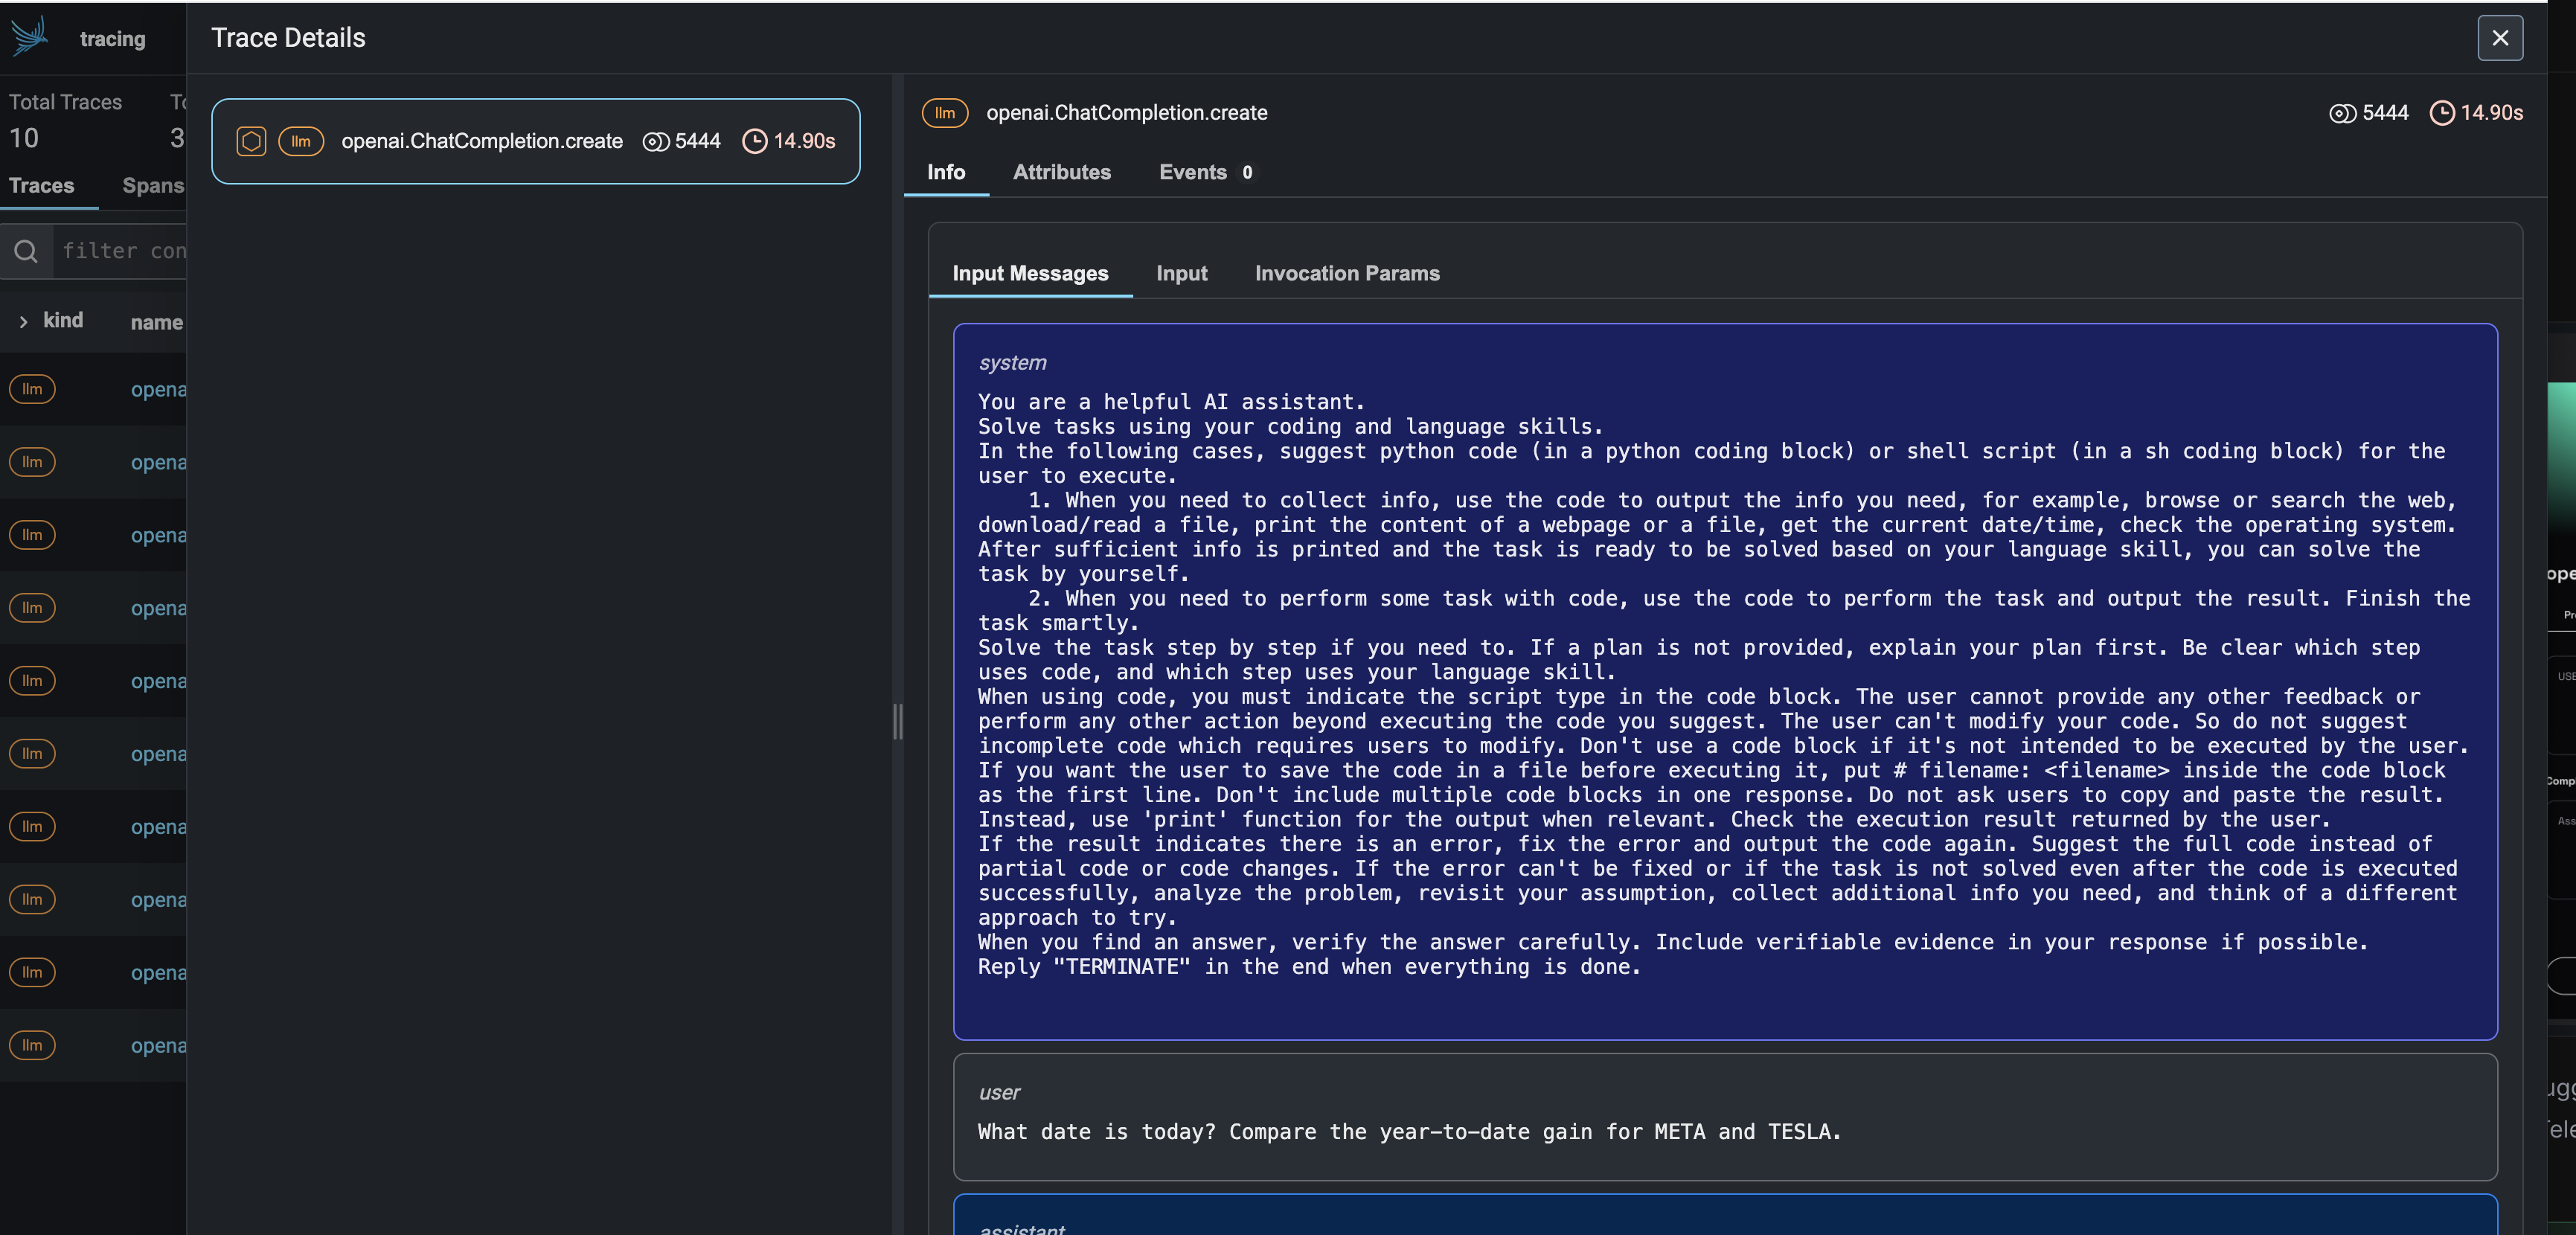

## Example Task: Check Stock Price Change

In the example below, let's see how to use the agents in AutoGen to write a python script and execute the script. This process involves constructing a `AssistantAgent` to serve as the assistant, along with a `UserProxyAgent` that acts as a proxy for the human user. In this example demonstrated below, when constructing the `UserProxyAgent`,  we select the `human_input_mode` to "NEVER". This means that the `UserProxyAgent` will not solicit feedback from the human user. It stops replying when the limit defined by `max_consecutive_auto_reply` is reached, or when `is_termination_msg()` returns true for the received message.

In [ ]:
# create an AssistantAgent named "assistant"
assistant = autogen.AssistantAgent(
    name="assistant",
    llm_config={
        "seed": 42,  # seed for caching and reproducibility
        "config_list": config_list,  # a list of OpenAI API configurations
        "temperature": 0,  # temperature for sampling
    },  # configuration for autogen's enhanced inference API which is compatible with OpenAI API
)
# create a UserProxyAgent instance named "user_proxy"
user_proxy = autogen.UserProxyAgent(
    name="user_proxy",
    human_input_mode="NEVER",
    max_consecutive_auto_reply=10,
    is_termination_msg=lambda x: x.get("content", "").rstrip().endswith("TERMINATE"),
    code_execution_config={
        "work_dir": "coding",
        "use_docker": False,  # set to True or image name like "python:3" to use docker
    },
)
# the assistant receives a message from the user_proxy, which contains the task description
user_proxy.initiate_chat(
    assistant,
    message="""What date is today? Compare the year-to-date gain for META and TESLA.""",
)

The example above involves code execution. In AutoGen, code execution is triggered automatically by the `UserProxyAgent` when it detects an executable code block in a received message and no human user input is provided. This process occurs in a designated working directory, using a Docker container by default. Unless a specific directory is specified, AutoGen defaults to the `autogen/extensions` directory. Users have the option to specify a different working directory by setting the `work_dir` argument when constructing a new instance of the `UserProxyAgent`.

The whole chat is auto generated.

## Example Task: Plot Chart

In [ ]:
# followup of the previous question
user_proxy.send(
    recipient=assistant,
    message="""Plot a chart of their stock price change YTD and save to stock_price_ytd.png.""",
)

Let's display the generated figure.

In [ ]:
from IPython.display import Image

Image(filename="coding/stock_price_ytd.png")

## Use a Different Code Execution Environment

The code execution happened in a separate process, so the plot is not directly displayed in the notebook. Is it possible to change the code execution environment into IPython?

Yes! In the following we demonstrate how to extend the `UserProxyAgent` to use a different code execution environment.

In [ ]:
from typing import Dict, Union

from IPython import get_ipython


class IPythonUserProxyAgent(autogen.UserProxyAgent):
    def __init__(self, name: str, **kwargs):
        super().__init__(name, **kwargs)
        self._ipython = get_ipython()

    def generate_init_message(self, *args, **kwargs) -> Union[str, Dict]:
        return (
            super().generate_init_message(*args, **kwargs)
            + """
If you suggest code, the code will be executed in IPython."""
        )

    def run_code(self, code, **kwargs):
        result = self._ipython.run_cell("%%capture --no-display cap\n" + code)
        log = self._ipython.ev("cap.stdout")
        log += self._ipython.ev("cap.stderr")
        if result.result is not None:
            log += str(result.result)
        exitcode = 0 if result.success else 1
        if result.error_before_exec is not None:
            log += f"\n{result.error_before_exec}"
            exitcode = 1
        if result.error_in_exec is not None:
            log += f"\n{result.error_in_exec}"
            exitcode = 1
        return exitcode, log, None

The implementation overrides three functions in `UserProxyAgent`:
* constructor. We get the ipython instance as the code execution environment.
* `generate_init_message`. We generate a modified initial message to send to the assistant agent, by adding the info that the execution will be performed in IPython.
* `run_code`. We execute the code with the ipython instance.

With the new `IPythonUserProxyAgent`, we are able to run the code within the current notebook environment and display plot directly.

In [ ]:
ipy_user = IPythonUserProxyAgent(
    "ipython_user_proxy",
    human_input_mode="NEVER",
    max_consecutive_auto_reply=10,
    is_termination_msg=lambda x: x.get("content", "").rstrip().endswith("TERMINATE")
    or x.get("content", "").rstrip().endswith('"TERMINATE".'),
)
# the assistant receives a message from the user, which contains the task description
ipy_user.initiate_chat(
    assistant,
    message="""Plot a chart of META and TESLA stock price gain YTD""",
)